# Introduction to Algorithmic Trading

Welcome to the Asset Trading Playground's *Introduction to Algorithmic Trading*! 

Provided that you've already finished the onboarding steps and have opened this notebook in an environment of your choice, you're ready to start learning about algorithmic trading and contributing to the project. This notebook is meant to provide a gentle introduction to some of the key concepts in algorithmic trading. Other notebooks in this instructional series will provide more mature examples which you can use as a base for your own experiments in the future.

## Initial Setup

These notebooks should be run using a kernel based on the *virtual environment* you create as a part of the project setup. If you are using JupyterLab, you can make your virtual environment accessible as a kernel  In order to make your virtual environment accessible as a kernel in a JupyterLab environment by actvating your virtual environment and entering the following command:

> python -m ipykernel install --user --name=*\<YOUR VENV NAME\>*

*\<YOUR VENV NAME\>* should now be acessible as a kernel for your JupyterLab environment.

## Data Ingestion

These demonstrations will all make use of data provided from the *PlaygroundData* package, using the FixerAPI Data pipeline that has been created. These enable users to easily request data for Forex currency pairs. Please ensure that you have completed the setup instructions provided in the *README* before continuing.

In this example, we request a Pandas DataFrame containing data for the USD/GBP currency pair between 2018-01-01 and 2020-01-01.

In [2]:
import PlaygroundData.FixerData as pdata
import pandas as pd
import numpy as np

FROM_CURR = "USD"
TO_CURR = "GBP"

fdrh = pdata.FixerDataRequestHandler()
data = fdrh.get_data({"start_date": "2015-01-01",
                      "end_date": "2020-01-01",
                      "from_curr": FROM_CURR,
                      "to_curr": TO_CURR})

data["Date"] = pd.to_datetime(data["Date"])
data.set_index(
    "Date",
    drop=True,
    inplace=True
)

Attempting to fetch data from SQL database.


Let's visualise datta this on a time series graph.

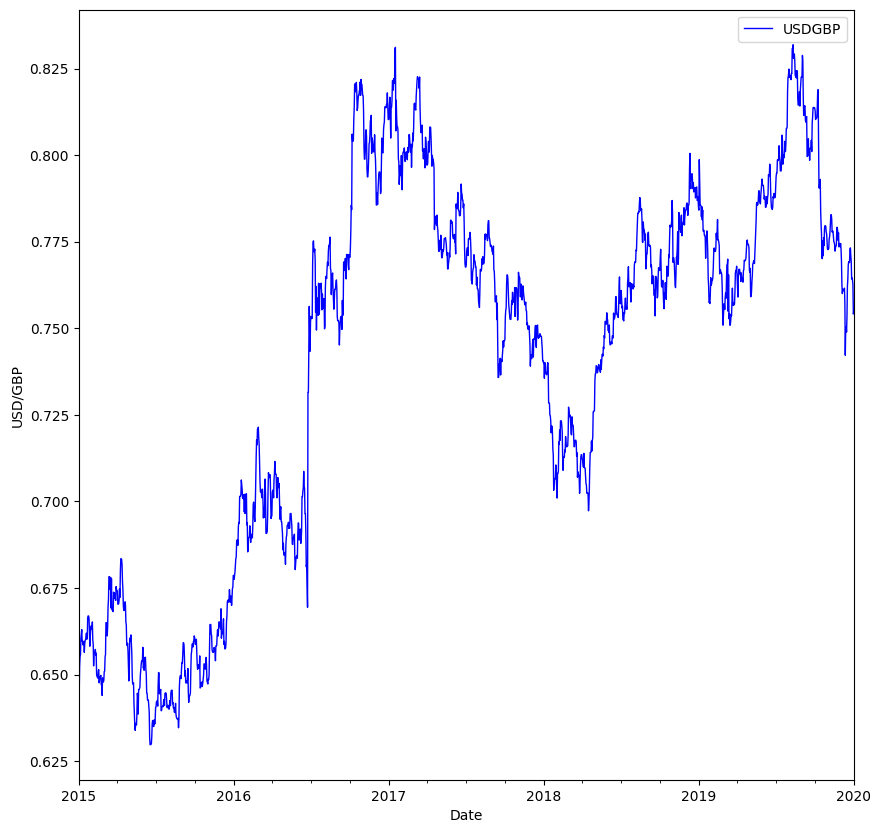

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, ylabel=f"{FROM_CURR}/{TO_CURR}")
data.plot(ax=ax1, color='b', lw=1)
plt.show()


This plot shows us the exchange rate from USD to GBP between 2018 and 2020. 

Let us say that on a given day, the exchange rate was 0.7 and we have \\$1000 and £1000. This would mean that 1 USD could be exchanged for 0.7 GBP. For simplicity, let's say that we want to maximise how many GBP we have. On this day, if we converted all of our USD to GBP, we would have 1000 * 0.7 = £700 from our currency exchange, and a total of £1700. 

If we knew that in 1 week, the exchange rate was going *rise* and become 0.8, then we know that USD is going to be worth much more compared to GBP in a week than it is today. If I was *absolutely certain* of my inside tip, I would convert all of my money into USD today, giving me

1000 + 1000 * (1 / 0.7)  =  $2428.57

In week's time, I would be able to sell my USD for GBP at a rate of 0.8. Let's just sell the amount over our initial \\$1000. This would give me:

(2428.57 - 1000) * 0.8 = £1142.85

If we compare our portfolios at the start and end of this process:

*Starting Portfolio*
> USD: 1000, GBP: 1000

*Final Portfolio*
> USD: 1000, GBP: 1142.85

**This is fantastic!** We went with our "inside tip" of where the currency conversion rate was going to go, and used this knowledge to make money with no risk. Sadly, this not how trading really works. Here are some reasons why:

1. **Uncertainty**. We have no way of being certain about where the currency exchange rate will go.
2. **Risk**. In our example, we put *all* of our GBP into USD, hoping for the price to do what we want. If the exchange rate had fallen suddenly, we could have ended up losing a vast percentage of our portfolio. On the other hand, if we hadn't taken any risk at all, we wouldn't have been able to make money if the exchange rate went up!

This means that if we want to become profitable traders, we need to *manage our relationship* these two things.

## Managing Uncertainty Using Technical Indicators

Algorithmic traders often seek to calculate various statistics called *technical indicators* from time-series data like the ones we have seen above to attempt to get a better understanding of their data. These can be calculated from our time series data and provide information about our time series, and make it easier to understand when we should take some action i.e. they are used to generate *trading signals*.

*Is a sudden rise in price indicative of a new rising trend, or is it just a spike which we can expect to come back down quickly?*

This is the sort of question that technical indicators are designed to help us to solve.

### Simple Moving Average

One of the most simple technical indicators we can use is the *Simple Moving Average*. This is derived from adding up previous values from a time series and taking their average. Let's look at a simple implementation of this using a 50-day average.

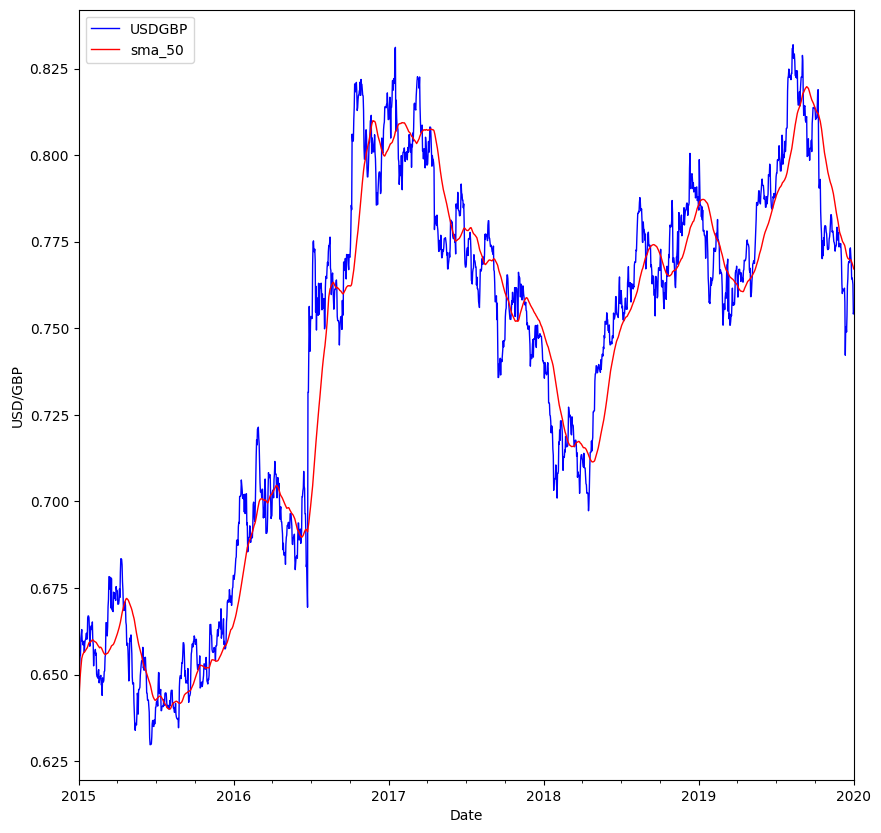

In [4]:
def sma(data, n, inplace=False):
    sma = data[f"{FROM_CURR}{TO_CURR}"].rolling(window=n, min_periods=1, center=False).mean()
    if inplace == False:
        return np.array(sma)
    else:
        data[f"sma_{n}"] = sma
        return np.array(sma)

n = 50
sma(data, n, inplace=True)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, ylabel=f"{FROM_CURR}/{TO_CURR}")

data[f"{FROM_CURR}{TO_CURR}"].plot(ax=ax1, color='b', lw=1, legend=True)
data[f"sma_{n}"].plot(ax=ax1, color='r', lw=1, legend=True)

plt.show()

The red line here represents a Simple Moving Average taken over 50 days i.e. at each point, the red line represents the average of the previous 50 days of data. Try changing the value of *n* in the code above to see a different window size.

As we can see, the values appear to be a more smoothed out version of the original time series, with fewer sudden jumps. Ideally, this would mean that rising and falling values of the SMA value would be more likely to indicate a trend which can be used to **reduce our uncertainty** about future changes.

### Exponential Moving Average

An alternative to SMA is the **Exponential Moving Average**, or **EMA**. The EMA is similar to the SMA, but follows the intuition that more recent values of the time series should be more relevant to the value of the indicator than less recent ones. For the SMA, an observation that was 50 days ago matters just as much as a value we saw 1 day ago. The EMA is defined by

> EMA  =  P * q  +  (1 - q) * EMA(old)

- P: Current price
- n: time periods\n
- q:  Smoothing constant, often 2/(n+1)\n
- EMA(old): the previous value of the EMA

By following the logic here, we can see that the EMA value consists of a sum of each value, but with each price getting an *exponentially* smaller weighting with each value that is calculated. 

Let's look at an implementation of this.

In [5]:
def ema(data, n, q, inplace=False):
    ema_list = []
    ema = 0
    for x in data[f"{FROM_CURR}{TO_CURR}"]:
        if ema == 0:
            ema = x
        else:
            ema = (q * x) + (1 - q) * (ema)
        ema_list.append(ema)
    if inplace == False:
        return ema_list
    else:
        data[f"ema_{n}"] = ema_list
        return ema_list
        

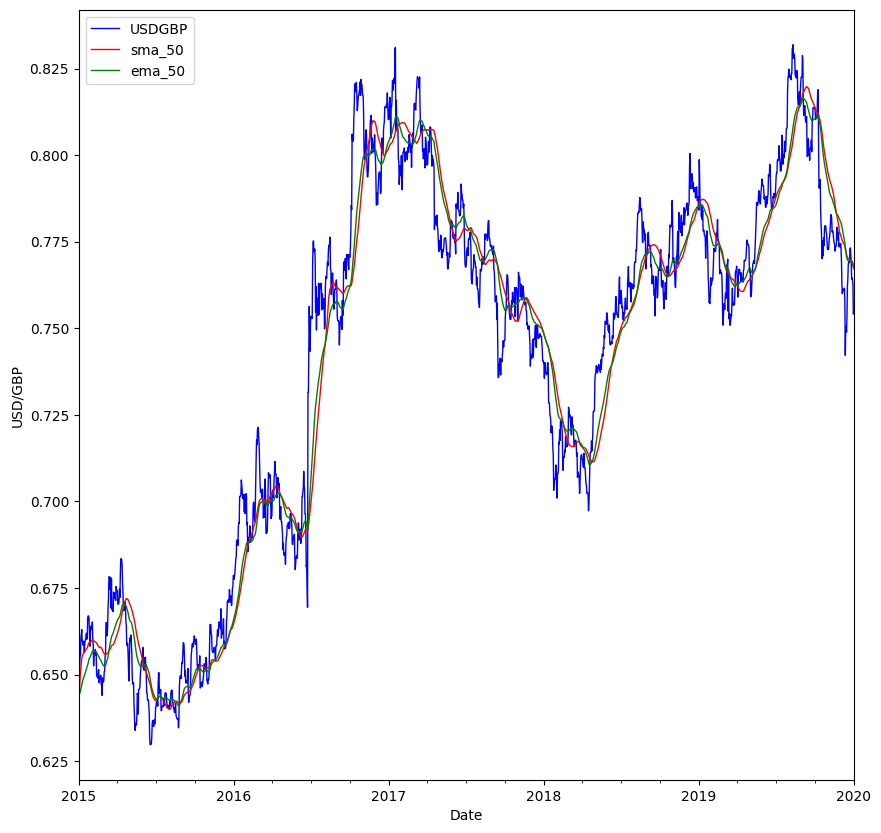

In [6]:
n = 50
ema(data, n, 2/(n+1), inplace=True)
sma(data, n, inplace=True)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, ylabel=f"{FROM_CURR}/{TO_CURR}")

data[f"{FROM_CURR}{TO_CURR}"].plot(ax=ax1, color='b', lw=1, legend=True)
data[f"sma_{n}"].plot(ax=ax1, color='r', lw=1, legend=True)
data[f"ema_{n}"].plot(ax=ax1, color='g', lw=1, legend=True)

plt.show()

By looking at a comparison of SMA and EM, we can see that the EMA produces a similar effect to SMA, but appears to hug the data slightly better. EMAs are an extremely popular choice for a technical indicator, and form the basis of many other indicators.

### Absolute Price Oscillator

One interesting application of EMAs is the **Absolute Price Oscillator**. This is an indicator which measures the difference between a short EMA and a long EMA. The intuition here is that if there is a big a difference between the short and long EMAs, a significant change in value occuring. In trading terminology, this behaviour is called a "breakout".

It is simply given by

> APO  =  EMA(n)  -  EMA(m),

where n and m are positive integers, n < m. Let us look at an implementation.


In [7]:
def apo(data, n, m, inplace=False):

    short_ema = ema(data, n, 2/(n+1))
    long_ema = ema(data, m, 2/(m+1))
    apo = pd.Series(short_ema) - pd.Series(long_ema)
    if inplace == False:
        return list(apo)
    else:
        data[f"apo_{n}_{m}"] = list(apo)
        return list(apo)
    

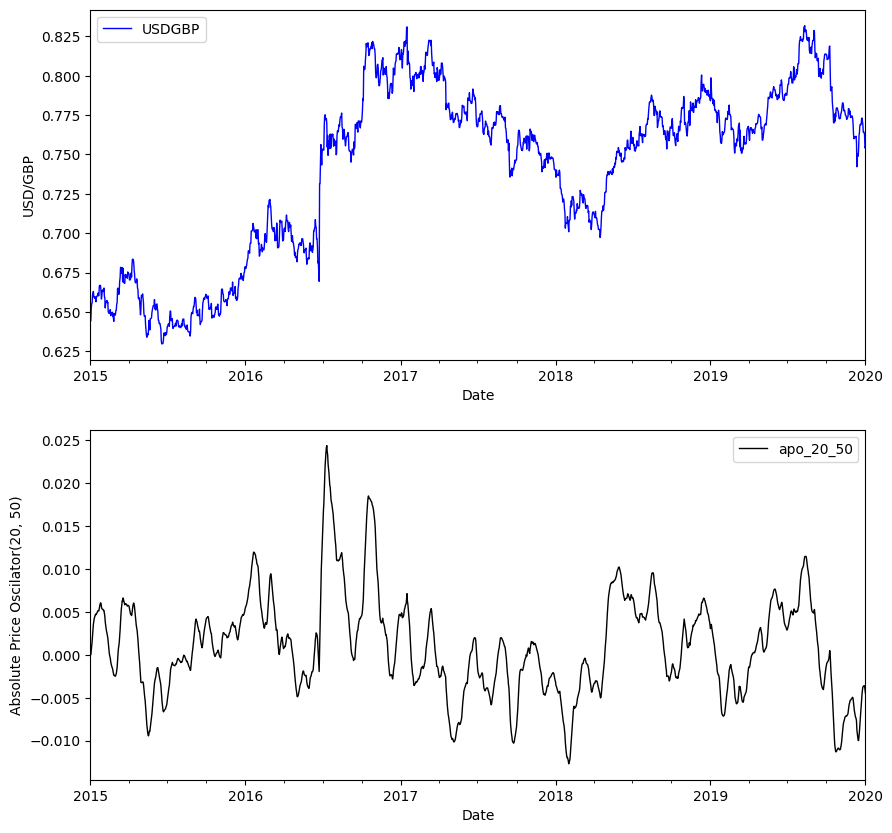

In [8]:
n = 20
m = 50

#ema(data, n, 2/(n+1), inplace=True)
#sma(data, n, inplace=True)
apo(data, n, m, inplace=True)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211, ylabel=f"{FROM_CURR}/{TO_CURR}")
ax2 = fig.add_subplot(212, ylabel=f"Absolute Price Oscilator({n}, {m})")

data[f"{FROM_CURR}{TO_CURR}"].plot(ax=ax1, color='b', lw=1, legend=True)
#data[f"sma_{n}"].plot(ax=ax1, color='g', lw=1, legend=True)
#data[f"ema_{n}"].plot(ax=ax1, color='r', lw=1, legend=True)
data[f"apo_{n}_{m}"].plot(ax=ax2, color='black', lw=1, legend=True)

plt.show()

By looking carefully, we can see that larger positive values of the APO appear to correspond with situations where the time series has a "positive breakout", whereas negative values correspond with situations where we have a "negative breakout".

### Bollinger Bands

Let us look at one more technical indicator in this notebook. Bollinger Bands are a method of using Simple Moving Average which also takes into account *recent price volatility from the SMA* - the amount that prices have been changing recently. It functions by creating a Simple Moving Average, and then bands above and below which correspond to addition and subtraction of some multiple of standard price deviations from the SMA

The intuition here is that if your SMA crosses the upper/lower band, then the movement has been "significant" relative to recent price volatility, and so this change in SMA could be indicative of a new trend.

We define

> - BBAND(mid)  =  SMA(n)
> - BBAND(up)  =  BBAND(mid) + (B * q)
> - BBAND(low)  =  BBAND(mid) - (B * q)

- B: arbitrary standard deviation factor
- q: standard deviation of price from SMA over n periods

Here is an implementation of this:

In [9]:
def boll_bands(data, n, B, inplace=False):
    
    sma_series = pd.Series(sma(data, n, inplace=False))
    std_dev_series = pd.Series(sma(data, n, inplace=False)).rolling(window=n).std()
    boll_upper = sma_series + (B * std_dev_series)
    boll_lower = sma_series - (B * std_dev_series)
    sma_list, boll_upper, boll_lower = np.array(sma_series), np.array(boll_upper), np.array(boll_lower)
    print(len(sma_series), len(boll_upper), len(boll_lower))
    if inplace == False:
        return sma_list, boll_upper, boll_lower
    else:
        data[f"sma_{n}"] = sma_list
        data["bband_upper"] = boll_upper
        data["bband_lower"] = boll_lower
        return sma_list, boll_upper, boll_lower

1827 1827 1827


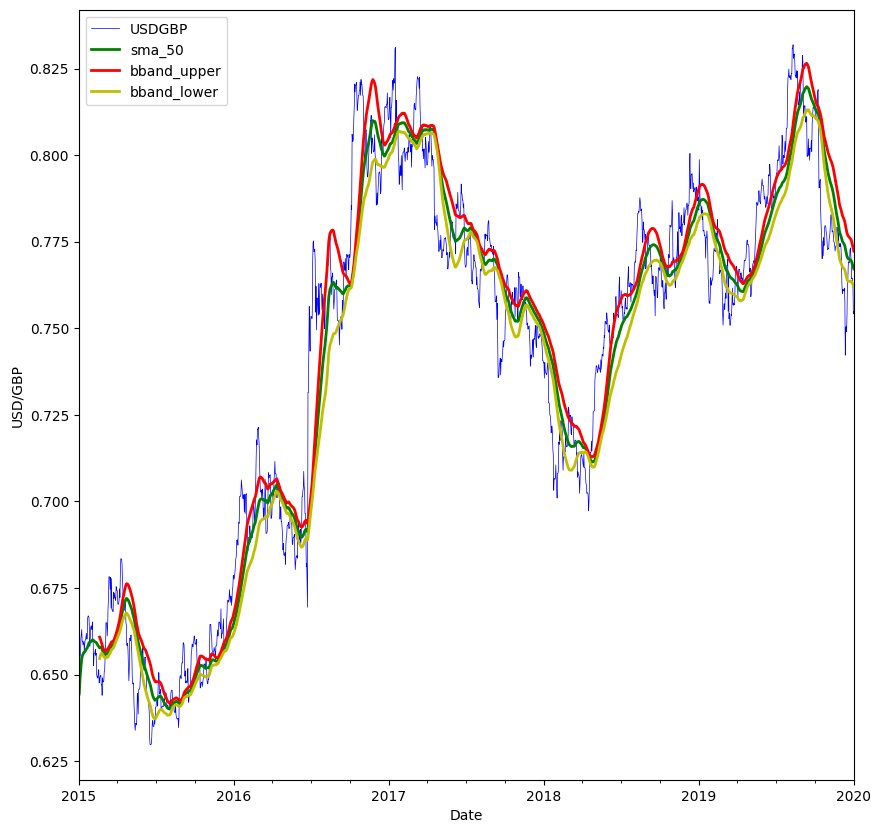

In [12]:
n = 50
B = .8

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, ylabel=f"{FROM_CURR}/{TO_CURR}")

boll_bands(data, n, B, inplace=True)

data[f"{FROM_CURR}{TO_CURR}"].plot(ax=ax1, color='b', lw=0.5, legend=True)
data[f"sma_{n}"].plot(ax=ax1, color='g', lw=2, legend=True)
data[f"bband_upper"].plot(ax=ax1, color='r', lw=2, legend=True)
data[f"bband_lower"].plot(ax=ax1, color='y', lw=2, legend=True)

plt.show()